In [1]:
import os
from glob import glob
import warnings
from datetime import datetime

import numpy as np
import pyart
from matplotlib import pyplot as plt
import cftime

import radar_codes
import attenuation
import rainrate
import file_util

import openradartools as ort

warnings.simplefilter('ignore')

from importlib import reload



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#config
vol_root = '/g/data/rq0/level_1/odim_pvol'
cf_root = '/scratch/kl02/jss548/dprain/cfradial'
rf_root = '/scratch/kl02/jss548/dprain/rfgrids'
VERBOSE = True

rid = 2
date_str = '20211022'
sweep_idx = 142

# rid = 71
# date_str = '20181213'
# sweep_idx = 84

# rid = 66
# date_str = '20181214'
# sweep_idx = 84

# rid = 2
# date_str = '20200119'
# sweep_idx = 60

# date_str = '20200519' #C band - Rainbow
# rid = 95

# date_str = '20200505' #C band - Albany
# rid = 31 #C band - Albany

In [3]:
#unpack and list daily zip
vol_zip = f'{vol_root}/{rid}/{date_str[0:4]}/vol/{rid}_{date_str}.pvol.zip'
temp_dir = True
temppath = ort.file.unpack_zip(vol_zip)
vol_ffn_list = sorted(glob(temppath + '/*.h5'))

In [4]:
rid = 2
vol_ffn = '/g/data/kl02/jss548/aura/testing_files/dp/2_20211201_132000.pvol.h5'

In [5]:
print('processing', vol_ffn)

#read radar volume
radar = pyart.aux_io.read_odim_h5(vol_ffn, file_field_names=True)
#get time
valid_time = cftime.num2pydate(radar.time['data'][0], radar.time['units'])

#get radar band
wavelength = ort.file.get_wavelength(vol_ffn)
if wavelength<8:
    band = 'C'
else:
    band = 'S'
if VERBOSE:
    print('band', band)
    
#index index of lowest sweep
scan_idx = np.argmin(radar.fixed_angle['data'])

processing /g/data/kl02/jss548/aura/testing_files/dp/2_20211201_132000.pvol.h5
band S


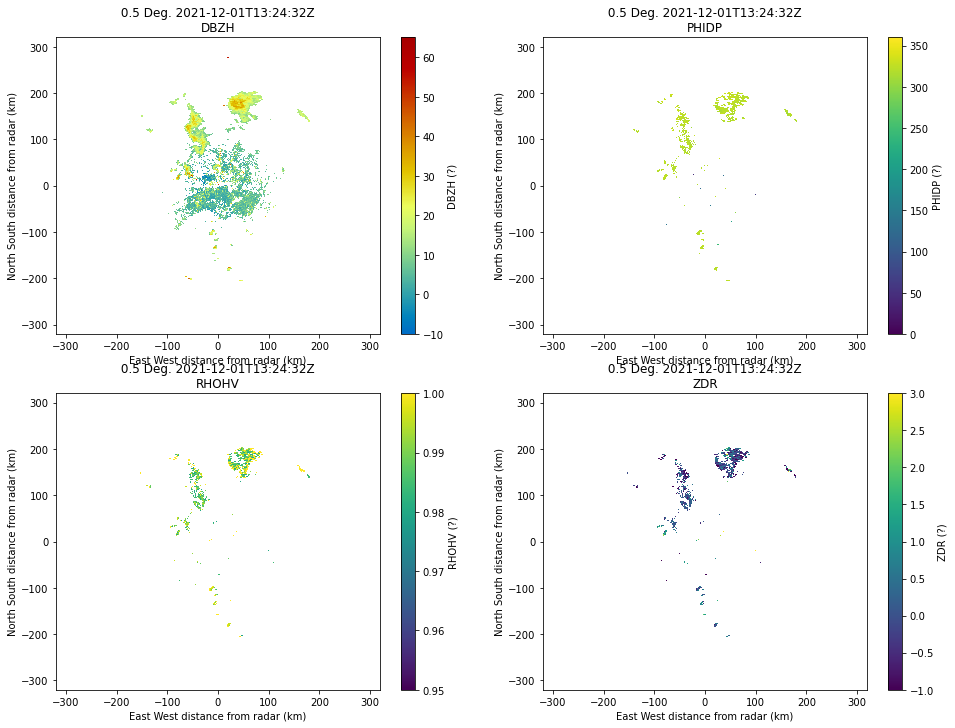

In [6]:
fig = plt.figure(figsize=[16,12])
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('RHOHV',0.98)
gatefilter.exclude_outside('DBZH',10,50)
gatefilter.exclude_outside('ZDR',-4,4)
ax = plt.subplot(221)
display.plot_ppi('DBZH', scan_idx)
ax = plt.subplot(222)
display.plot_ppi('PHIDP', scan_idx,
                gatefilter=gatefilter, vmin=0, vmax=360)
ax = plt.subplot(223)
display.plot_ppi('RHOHV', scan_idx,
                 gatefilter=gatefilter, vmin=0.95, vmax=1.0)
ax = plt.subplot(224)
display.plot_ppi('ZDR', scan_idx,
                gatefilter=gatefilter, vmin=-1, vmax=3)
#apply alpha filters to check remaining valid data

In [7]:
##################################################################################################
#
# Preprocessing
#
##################################################################################################

# Correct RHOHV
rho_corr = ort.dp.correct_rhohv(radar, snr_name='SNRH')
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing=True)

# Correct ZDR
corr_zdr = ort.dp.correct_zdr(radar, snr_name='SNRH')
radar.add_field_like('ZDR', 'ZDR_CORR', corr_zdr, replace_existing=True)

# Temperature    
height, temperature, isom, profiles, levels = ort.nwp.nwp_profile(radar, source='access')
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('height_over_isom', isom, replace_existing=True)

# GateFilter
gatefilter = ort.dp.do_gatefilter(radar,
                                     refl_name='DBZH',
                                     phidp_name="PHIDP",
                                     rhohv_name='RHOHV_CORR',
                                     zdr_name="ZDR_CORR")


In [8]:
# phidp filtering
#shift the system phase
rawphi = radar.fields["PHIDP"]['data']
sysphase_gatefilter = gatefilter.copy()
sysphase_gatefilter.exclude_below('RHOHV_CORR', 0.95)
sysphase = ort.dp.det_sys_phase_gf(radar, sysphase_gatefilter, phidp_field="PHIDP", sweep=scan_idx)

if sysphase is None:
        radar.add_field_like("PHIDP", "PHIDP_offset", rawphi, replace_existing=True)
        print('failed to find system phase')
else:
    tmp = rawphi - sysphase
    tmp[np.isnan(tmp)] = -9999
    radar.add_field_like("PHIDP", "PHIDP_offset", tmp, replace_existing=True)
    print('system phase:', round(sysphase))


system phase: 316


In [9]:
#correct phase
#calculate phidp from bringi technique
phidp_b, kdp_b = ort.dp.phidp_bringi(radar, gatefilter, phidp_field="PHIDP_offset", refl_field='DBZH')
radar.add_field("PHIDP_B", phidp_b, replace_existing=True)
radar.add_field('KDP_B', kdp_b, replace_existing=True)

kdp_name = 'KDP_B'
phidp_name = 'PHIDP_B'

#first try to use exisiting NCAR HCA into a field. Sometimes it is missing due a missing DP fields.
try:
    hca_field = ort.dp.insert_ncar_pid(radar, vol_ffn, dbz_name='DBZH')
except:
    #insert CSU HCA if NCAR PID is not in the file
    hca_field = ort.dp.csu_hca(radar,
                                      gatefilter,
                                      kdp_name=kdp_name,
                                      zdr_name='ZDR_CORR',
                                      rhohv_name='RHOHV_CORR',
                                      refl_name='DBZH',
                                      band=band)
radar.add_field('radar_echo_classification', hca_field, replace_existing=True)

In [10]:
##################################################################################################
#
# Retrievals
#
##################################################################################################
from importlib import reload
reload(rainrate)
reload(attenuation)

#estimate alpha
alpha, alpha_method = attenuation.estimate_alpha_zhang2020(radar, band, scan_idx,
                                       refl_field='DBZH', zdr_field='ZDR_CORR', rhohv_field='RHOHV_CORR',
                                       verbose=True)

#estimate specific attenuation
if VERBOSE:
    print('alpha', alpha, 'alpha method', alpha_method)
radar = attenuation.retrieve_zphi(radar, band, alpha=alpha, alpha_method=alpha_method,
                                 refl_field='DBZH', phidp_field=phidp_name, rhohv_field='RHOHV_CORR')

#estimate rainfall
radar = rainrate.conventional(radar, alpha=92, beta=1.7, refl_field='corrected_reflectivity')
radar = rainrate.polarimetric(radar, band, refl_field='corrected_reflectivity',
                              kdp_field=kdp_name, phidp_field=phidp_name, rhohv_field='RHOHV_CORR')

defaults 0.020376968411994913 0.03527345232514318
temp: 18.731963452799945 C


case 1 valid bins 1
case 1 thresholds 8
case 1a valid bins 0
case 1a thresholds 3
case 2 valid bins 1
case 2 thresholds 11
case 3 valid bins 1
case 3 thresholds 9
case 4 False
case 4 total count 9.0
case 4 min 50

5: default stratiform
alpha value 0.03527345232514318
alpha 0.03527345232514318 alpha method 5


In [11]:
##################################################################################################
#
# Gridding
#
##################################################################################################


# grid first two sweeps (second sweep used as a fallback where the lower grid has no data)
sort_idx = np.argsort(radar.fixed_angle['data'])
data_sweep1 = radar.get_field(sort_idx[0], 'hybrid_rainrate', copy=True).filled(np.nan)
data_sweep2 = radar.get_field(sort_idx[1], 'hybrid_rainrate', copy=True).filled(np.nan)
data_combined = np.nanmax(np.stack((data_sweep1, data_sweep2), axis=2), axis=2)


#build metadata and grid
r = radar.range['data']
th = 450 - radar.get_azimuth(sort_idx[0], copy=False)
th[th < 0] += 360
R, A = np.meshgrid(r, th)
x = R * np.cos(np.pi * A / 180)
y = R * np.sin(np.pi * A / 180)
xgrid = np.linspace(-127750,127750,512)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
gatespacing = r[1]-r[0]

fields_ppi = {'rainrate':data_combined} 

fields_grid = ort.gridding.KDtree_interp(fields_ppi, x, y, xgrid, ygrid, nnearest = 24, maxdist = 2500)

rain_grid_2d = fields_grid['rainrate']

(-150.0, 150.0)

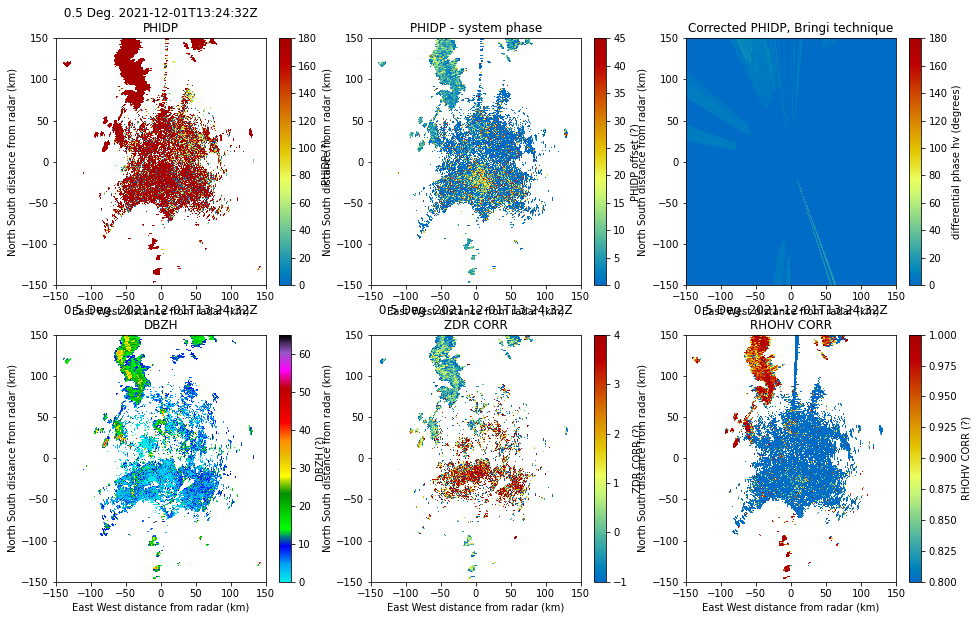

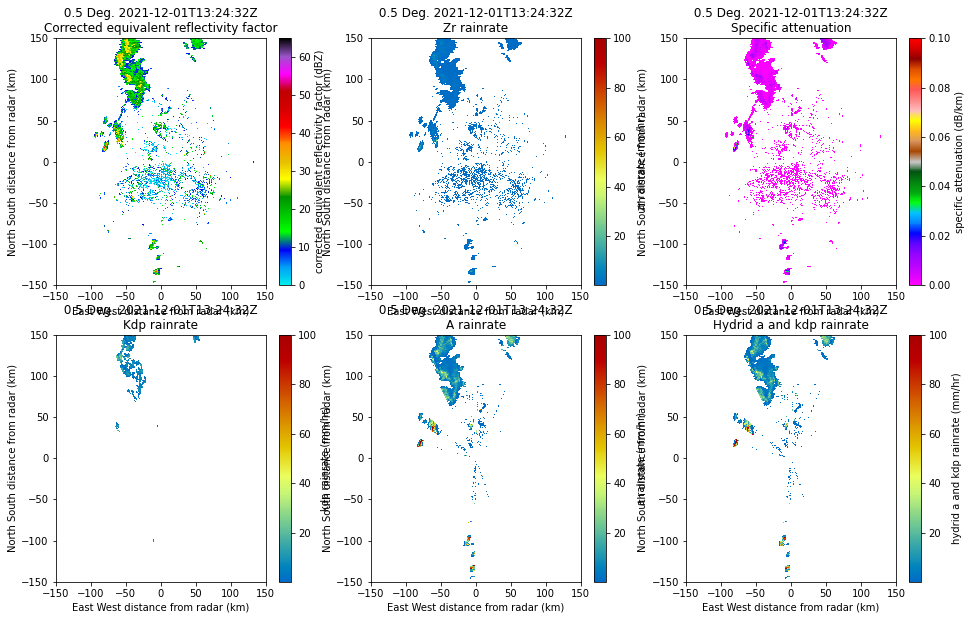

In [12]:
#corrected DBZH for rainfall

tilt = scan_idx
ylim = [-150, 150]
xlim = [-150, 150]
# ylim = [25, 50]
# xlim = [-70, -30]

#restore hail pixels
pid = radar.fields['radar_echo_classification']['data']
gatefilter.include_gates(pid==9)

###################################################################################################################

fig = plt.figure(figsize=[16,10])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(231)
display.plot_ppi('PHIDP', tilt, vmin=0, vmax=180, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(232)
display.plot_ppi('PHIDP_offset', tilt, vmin=0, vmax=45, cmap='pyart_HomeyerRainbow', title='PHIDP - system phase')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(233)
display.plot_ppi('PHIDP_B', tilt, vmin=0, vmax=180, cmap='pyart_HomeyerRainbow', title='Corrected PHIDP, Bringi technique')
ax.set_xlim(xlim)
ax.set_ylim(ylim)


ax = plt.subplot(234)
display.plot_ppi('DBZH', tilt, vmin=0, vmax=65, cmap='pyart_NWSRef')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(235)
display.plot_ppi('ZDR_CORR', tilt, vmin=-1, vmax=4, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(236)
display.plot_ppi('RHOHV_CORR', tilt, vmin=0.8, vmax=1, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)



###################################################################################################################

fig = plt.figure(figsize=[16,10])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(231)
display.plot_ppi('corrected_reflectivity', tilt, gatefilter=gatefilter, vmin=0, vmax=65, cmap='pyart_NWSRef')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(232)
display.plot_ppi('zr_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(233)
display.plot_ppi('specific_attenuation', tilt, gatefilter=gatefilter, vmin=0.0, vmax=0.1, cmap='pyart_Wild25')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(234)
display.plot_ppi('kdp_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(235)
display.plot_ppi('ah_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(236)
display.plot_ppi('hybrid_rainrate', tilt, gatefilter=gatefilter, vmin=0.2, vmax=100, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# ###################################################################################################################

# fig = plt.figure(figsize=[12,5])
# display = pyart.graph.RadarDisplay(radar)

# ax = plt.subplot(131)
# display.plot_ppi('zr_rainrate', tilt, vmin=0.5, vmax=100, cmap='pyart_HomeyerRainbow')

# ax = plt.subplot(132)
# display.plot_ppi('ah_a_array', tilt, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow', title='R(A) a parameter')

# ax = plt.subplot(133)
# display.plot_ppi('ah_b_array', tilt, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow', title='R(A) b parameter')



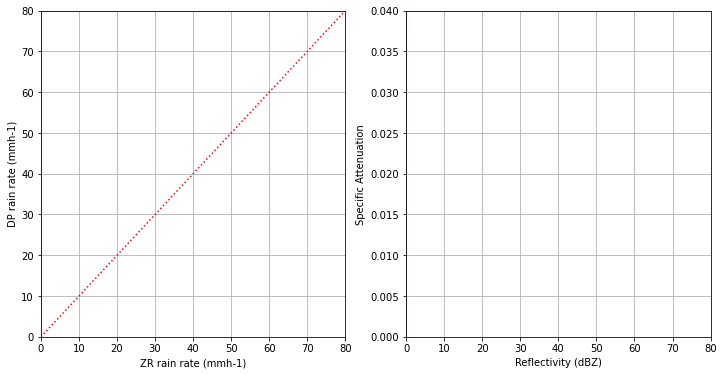

In [15]:
plt.figure(figsize=[12,6])
sl = radar.get_slice(0)

ax = plt.subplot(121)
x_val = radar.fields['zr_rainrate']['data'][sl].flatten()
y_val = radar.fields['ah_rainrate']['data'][sl].flatten()
filt = np.logical_and(x_val>0, y_val>0)
x_val = x_val[filt]
y_val = y_val[filt]

plt.plot(x_val, y_val, 'k.', ms=0.5)
plt.xlim([0, 80])
plt.ylim([0, 80])
plt.xlabel('ZR rain rate (mmh-1)')
plt.ylabel('DP rain rate (mmh-1)')
plt.grid()
plt.plot([0,80],[0,80],'r:')

ax = plt.subplot(122)
x_val = radar.fields['DBZH']['data'][sl].flatten()
y_val = radar.fields['specific_attenuation']['data'][sl].flatten()
filt = np.logical_and(x_val>0, y_val>0)
x_val = x_val[filt]
y_val = y_val[filt]

plt.plot(x_val, y_val, 'k.', ms=0.5)
plt.xlim([0, 80])
plt.ylim([0, 0.04])
plt.xlabel('Reflectivity (dBZ)')
plt.ylabel('Specific Attenuation')
plt.grid()
plt.plot([0,0.04],[0,80],'r:')


(-50.0, 0.0)

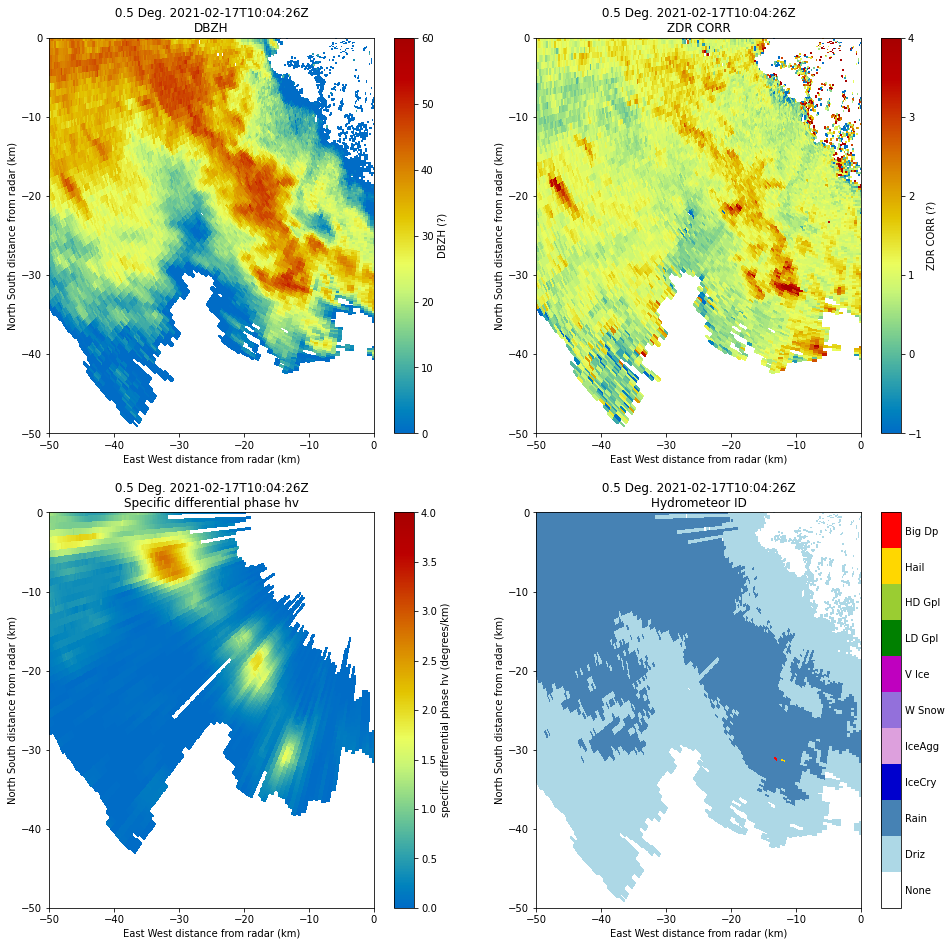

In [16]:
  
ncar_cmap = ort.plot.ncar_color_map()
csu_cmap = ort.plot.csu_color_map()

###################################################################################################################
ylim = [-50, 0]
xlim = [-50, 0]

fig = plt.figure(figsize=[16,16])
display = pyart.graph.RadarDisplay(radar)

ax = plt.subplot(221)
display.plot_ppi('DBZH', tilt, vmin=0, vmax=60, gatefilter=gatefilter, cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(222)
display.plot_ppi('ZDR_CORR', tilt, vmin=-1, vmax=4, gatefilter=gatefilter,cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(223)
display.plot_ppi('KDP_B', tilt, vmin=0, vmax=4, gatefilter=gatefilter,cmap='pyart_HomeyerRainbow')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax = plt.subplot(224)

if radar.fields['radar_echo_classification']['long_name'] == 'NCAR Hydrometeor classification':
    display.plot_ppi('radar_echo_classification',  tilt, gatefilter=gatefilter, cmap=ncar_cmap, vmin=0, vmax=20)
    display.cbs[3] = ort.plot.adjust_ncarpid_scheme_colorbar_for_pyart(display.cbs[3])
else:
    display.plot_ppi('radar_echo_classification',  tilt, gatefilter=gatefilter, cmap=csu_cmap, vmin=0, vmax=11)
    display.cbs[3] = ort.plot.adjust_csuhca_scheme_colorbar_for_pyart(display.cbs[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

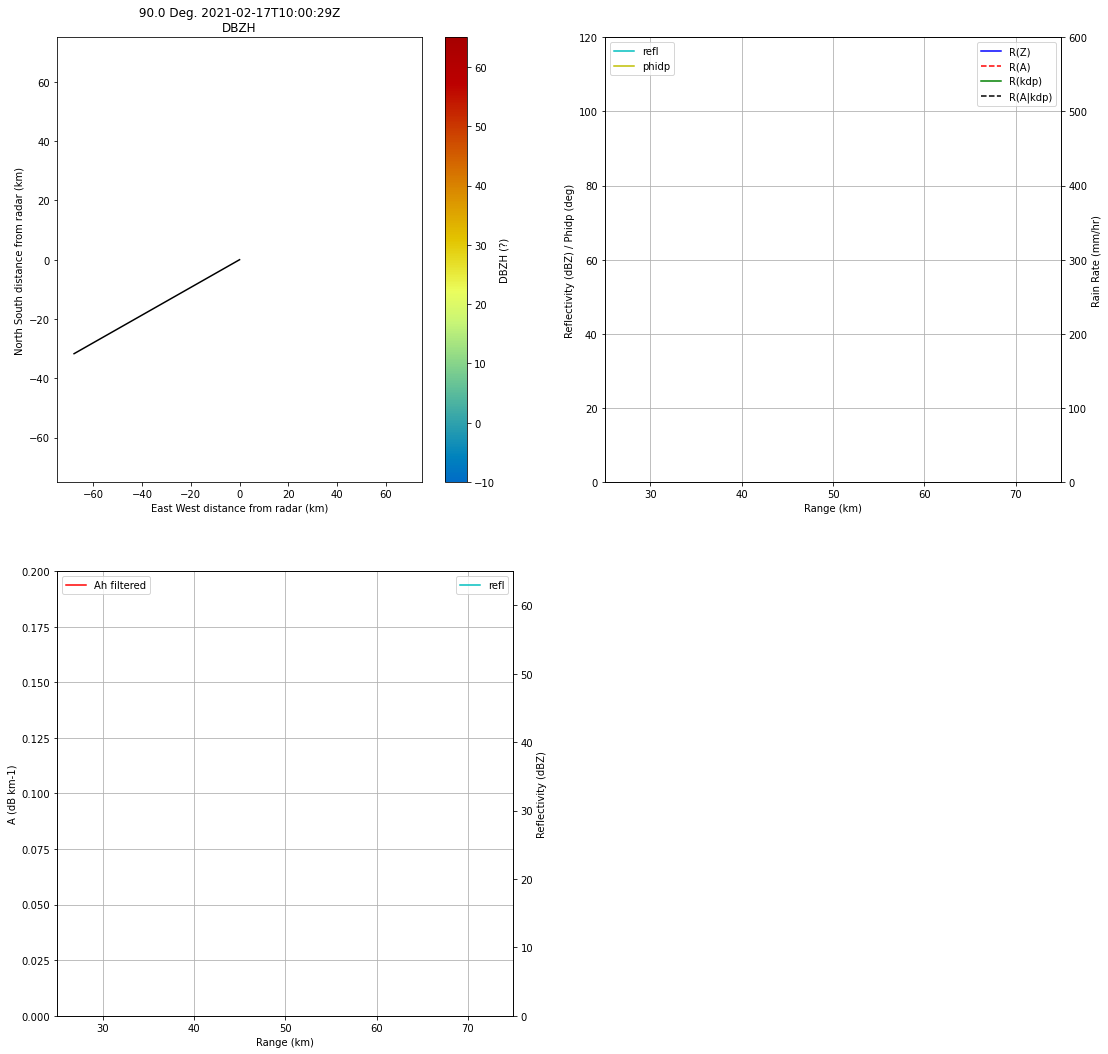

In [17]:
def plot_cross_hair(size, angle, npts=100, ax=None):
    """
    Plot a cross-hair on a ppi plot.

    Parameters
    ----------
    size : float
        Size of cross-hair in km.
    npts: int
        Number of points in the cross-hair, higher for better resolution.
    ax : Axis
        Axis to plot on. None will use the current axis.

    """    
    #angle = angle.to('radians').m
        
    r = np.linspace(0, size, npts)
    
    x = r*np.sin(np.radians(angle))
    y = r*np.cos(np.radians(angle))
    
    ax.plot(x, y, 'k-')  # verticle


rhi_angle = 245
range_min = 25
range_max = 75
tilt_idx = 0
ylim = [-75, 75]
xlim = [-75, 75]

#plot reflectivity PPI
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[18,18])
ax = plt.subplot(221)
display.plot_ppi('DBZH', tilt_idx, gatefilter=gatefilter)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plot_cross_hair(range_max, rhi_angle, npts=100, ax=ax)

#extract rhi at azimuth
rhi_data = pyart.util.cross_section_ppi(radar, [rhi_angle])
range_array = rhi_data.range['data']/1000
range_mask = np.logical_and(range_array>2, range_array<range_max)
hca_ray = rhi_data.fields['radar_echo_classification']['data'][tilt_idx,:]
hca_mask = np.ma.getmask(hca_ray)
valid_mask = np.logical_and(range_mask, ~hca_mask)

#plot refl/phidp
refl_ray = rhi_data.fields['DBZH']['data'][tilt_idx,:]
phidp_ray = rhi_data.fields['PHIDP_B']['data'][tilt_idx,:]
ah_ray = rhi_data.fields['specific_attenuation']['data'][tilt_idx,:]

rain_z_ray = rhi_data.fields['zr_rainrate']['data'][tilt_idx,:]
rain_ah_ray = rhi_data.fields['ah_rainrate']['data'][tilt_idx,:]
rain_kdp_ray = rhi_data.fields['kdp_rainrate']['data'][tilt_idx,:]
rain_ah_kdp_ray = rhi_data.fields['hybrid_rainrate']['data'][tilt_idx,:]

ax = plt.subplot(222)
ax2 = ax.twinx()
ax.plot(range_array[valid_mask], refl_ray[valid_mask], 'c-', label='refl')
ax.plot(range_array[valid_mask], phidp_ray[valid_mask], 'y-', label='phidp')

ax2.plot(range_array[valid_mask], rain_z_ray[valid_mask], 'b-', label='R(Z)')
ax2.plot(range_array[valid_mask], rain_ah_ray[valid_mask], 'r--', label='R(A)')
ax2.plot(range_array[valid_mask], rain_kdp_ray[valid_mask], 'g-', label='R(kdp)')
ax2.plot(range_array[valid_mask], rain_ah_kdp_ray[valid_mask], 'k--', label='R(A|kdp)')
ax.set_ylabel('Reflectivity (dBZ) / Phidp (deg)')
ax.set_xlim([range_min,range_max])
ax.set_ylim([0,120])
ax2.set_ylim([0,600])
ax.grid()
ax2.set_ylabel('Rain Rate (mm/hr)')
ax.set_xlabel('Range (km)')
ax.legend(loc='upper left')
ax2.legend()

ax = plt.subplot(223)
ax2 = ax.twinx()
ax.plot(range_array[valid_mask], ah_ray[valid_mask], 'r-', label='Ah filtered')
ax2.plot(range_array[valid_mask], refl_ray[valid_mask], 'c-', label='refl')
ax.set_ylabel('A (dB km-1)')
ax2.set_ylabel('Reflectivity (dBZ)')
ax.set_xlim([range_min,range_max])
ax.set_ylim([0,0.2])
ax2.set_ylim([0,65])
ax.grid()
ax.set_xlabel('Range (km)')
ax.legend(loc='upper left')
ax2.legend()

#plot rainfall

In [18]:
##################################################################################################
#
# Investigation of sensitivity to Z and ZDR calibration
#
##################################################################################################

from importlib import reload
reload(rainrate)
reload(attenuation)

#estimate alpha
alpha_offset, alpha_offset_method = attenuation.estimate_alpha_zhang2020(radar, band, scan_idx,
                                       refl_field='DBZH', zdr_field='ZDR_CORR', rhohv_field='RHOHV_CORR',
                                       verbose=True, z_offset=-5, zdr_offset=-1)

#estimate specific attenuation
radar = attenuation.retrieve_zphi(radar, band, alpha=alpha_offset, alpha_method=alpha_offset_method,
                                 refl_field='DBZH', phidp_field=phidp_name, rhohv_field='RHOHV_CORR',
                                 ah_field='specific_attenuation_offset',
                                 z_offset=-5)

#estimate rainfall
radar = rainrate.conventional(radar, alpha=92, beta=1.7, refl_field='corrected_reflectivity', zr_field='zr_rainrate_offset',
                              z_offset=-5)
radar = rainrate.polarimetric(radar, band, refl_field='corrected_reflectivity',
                              kdp_field=kdp_name, phidp_field=phidp_name, rhohv_field='RHOHV_CORR',
                              ah_field='specific_attenuation_offset',
                              ahr_field='ah_rainrate_offset', kdpr_field='kdp_rainrate_offset', hybridr_field='hybrid_rainrate_offset',
                              z_offset=-5)

defaults 0.06826943187228983 0.08675425946749211
temp: 22.59420092357557 C


case 1 valid bins 12
case 1 thresholds 8
case 1a valid bins 1
case 1a thresholds 3
case 2 valid bins 11
case 2 thresholds 11
case 3 valid bins 16
case 3 thresholds 9
case 4 True
case 4 total count 139.0
case 4 min 50

2: 10-30dBZ valid, used default stratiform
alpha value 0.08675425946749211


Text(0, 0.5, 'Uncalibrated Rainrate (mm/hr)')

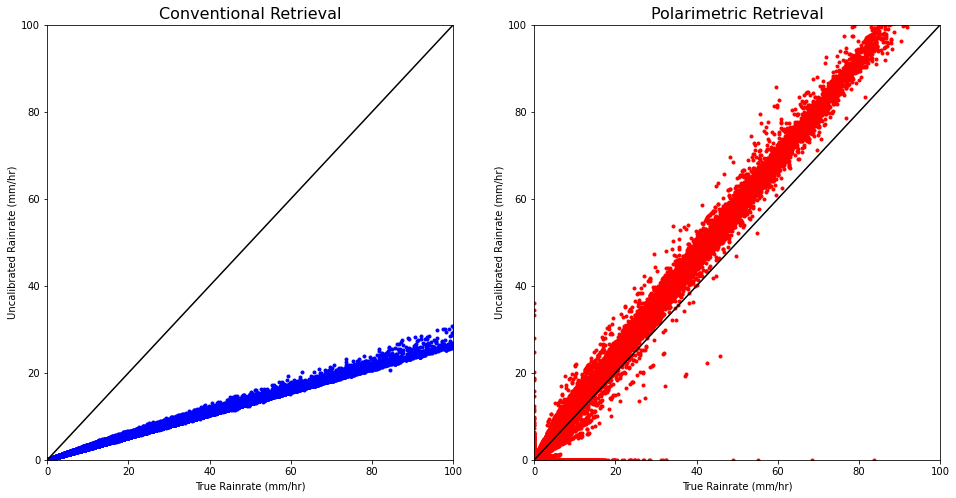

In [19]:
#plot
fig = plt.figure(figsize=[16,8])

zr_rr = radar.fields['zr_rainrate']['data'].flatten()
zr_rr_offset = radar.fields['zr_rainrate_offset']['data'].flatten()

ax = plt.subplot(121)
plt.plot(zr_rr, zr_rr_offset, 'b.')
plt.plot([0,100],[0,100],'k-')
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('Conventional Retrieval', FontSize=16)
plt.xlabel('True Rainrate (mm/hr)')
plt.ylabel('Uncalibrated Rainrate (mm/hr)')


ah_rr = radar.fields['ah_rainrate']['data'].flatten()
ah_rr_offset = radar.fields['ah_rainrate_offset']['data'].flatten()

ax = plt.subplot(122)
plt.plot(ah_rr, ah_rr_offset, 'r.')
plt.plot([0,100],[0,100],'k-')
plt.xlim([0,100])
plt.ylim([0,100])
plt.title('Polarimetric Retrieval', FontSize=16)
plt.xlabel('True Rainrate (mm/hr)')
plt.ylabel('Uncalibrated Rainrate (mm/hr)')